# Projektni zadatak
### Predmet: Genomska informatika
### Tema: Analiza razlike u ekspresiji gena izmedju dve sample grupe
### Autor: Adis Dijab 17/3245

#### 1. Deo - Kvantifikacija ekspresije gena za svaki sample pojedinacno

In [1]:
import pysam

#funkcija read_count vraca broj readova unutar bamfile-a koji se preklapaju sa genom
def read_count(gene, bamfile):
    
    bam_iter = bamfile.fetch(gene[0], gene[1], gene[2])
    
    return sum(1 for _ in bam_iter)

In [2]:
genes = []

#citanje gena iz fajla i sortiranje po nazivu gena
with open('gencode.v27.chr20.bed', 'r') as gencode_file:
    
    for line in gencode_file:
        
        gene = line.rstrip().split('\t')
        
        gene[1], gene[2] = int(gene[1]), int(gene[2])
        
        genes.append(gene)
        
genes = sorted(genes, key = lambda gene: gene[3])        

In [3]:
%%time

#kvantifikacija ekspresije na nivou gena za svaki sample iz bamfile-ova

samples_gene_counts = {}

for i in range(10):
    
    sample_label = 'sample_' + ('0' if i < 9 else '') + str(i + 1)

    file_name = '3245/' + sample_label + '_accepted_hits.bam'

    sample_bamfile = pysam.AlignmentFile(file_name, 'rb')

    gene_counts = [read_count(gene, sample_bamfile) for gene in genes]

    samples_gene_counts.update({sample_label: gene_counts})
        


CPU times: user 51.1 s, sys: 7.71 s, total: 58.8 s
Wall time: 1min 23s


In [4]:
import pandas as pd

#prikaz rezultata kvantifikacija ekspresije na nivou gena za svaki sample
df = pd.DataFrame(samples_gene_counts)
df.set_axis(list(map(lambda gene: gene[3], genes)), axis = 'index', inplace = True)

df.head(10)

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_10
5S_rRNA,96,77,44,42,56,124,77,40,88,74
5S_rRNA,0,0,0,0,0,0,0,0,0,0
5_8S_rRNA,104,66,20,98,48,72,60,193,62,122
5_8S_rRNA,0,0,0,0,0,0,0,0,0,0
5_8S_rRNA,0,0,0,0,0,0,0,0,0,0
AAR2,933,674,453,712,556,1354,984,1463,754,829
ABALON,1288,1144,892,934,758,1912,1479,2085,906,1236
ABBA01031660.1,943,805,608,710,647,810,652,870,399,496
ABBA01031661.1,667,659,491,511,551,1267,771,1239,545,828
ABBA01031663.1,1114,815,591,874,532,728,656,847,444,532


#### 2.Deo - RLE normalizacija

In [18]:
#uklanjane gena koji nisu ekspresovani ni u jednom sample-u

df = df.loc[~(df==0).any(axis = 1)]
df.head(10)

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_10
5S_rRNA,96,77,44,42,56,124,77,40,88,74
5_8S_rRNA,104,66,20,98,48,72,60,193,62,122
AAR2,933,674,453,712,556,1354,984,1463,754,829
ABALON,1288,1144,892,934,758,1912,1479,2085,906,1236
ABBA01031660.1,943,805,608,710,647,810,652,870,399,496
ABBA01031661.1,667,659,491,511,551,1267,771,1239,545,828
ABBA01031663.1,1114,815,591,874,532,728,656,847,444,532
ABBA01031674.1,380,480,341,359,249,696,403,774,371,390
ABHD12,2496,2253,1652,1721,1599,3933,2884,4234,1659,2675
ABHD16B,2329,1870,1581,1680,1506,5839,4412,6293,2808,4124


In [21]:
from scipy import stats

#geometrijske sredine ekspresije po genu u svim sample-ovima

geometric_means = stats.gmean(df, axis = 1)

geometric_means

array([  67.2874197 ,   72.60837479,  819.96978479, ..., 1546.24448961,
       1622.21324885,  165.07910828])

In [23]:
import numpy as np

# racunanje faktora normalizacije tako sto se nadje mediana svakog sample-a 
# podeljenog sa odgovrajucom gemetrijskom sredinom
counts_div_means = []

for i in range(df.shape[0]):
    count_div_mean = []
    for j in range(df.shape[1]):
        count_div_mean.append(float(df.iloc[i, j])/geometric_means[i])
    counts_div_means.append(count_div_mean)   

normalization_factors = np.median(np.array(counts_div_means), axis = 0)
normalization_factors

array([1.0722998 , 0.87445221, 0.66902804, 0.84180992, 0.66204323,
       1.60190021, 1.22519482, 1.73505855, 0.811297  , 1.08234941])

In [24]:
normdf = df.astype(float)

#normalizacija

for i in range(normdf.shape[0]):
    for j in range(normdf.shape[1]):
        normdf.iloc[i, j] = normdf.iloc[i, j]/normalization_factors[j]
normdf.head(10)

,sample_01,sample_02,sample_03,sample_04,sample_05,sample_06,sample_07,sample_08,sample_09,sample_10
5S_rRNA,89.527201,88.055127,65.767049,49.892498,84.586621,77.408068,62.847148,23.053977,108.468292,68.369788
5_8S_rRNA,96.987801,75.475823,29.894113,116.415829,72.502818,44.946620,48.971804,111.235439,76.420842,112.717759
AAR2,870.092488,770.768253,677.101664,845.796635,839.824311,845.246162,803.137578,843.199209,929.376045,765.926410
ABALON,1201.156618,1308.247599,1333.277450,1109.514125,1144.940338,1193.582468,1207.154958,1201.688552,1116.730367,1141.960244
ABBA01031660.1,879.418238,920.576326,908.781042,843.420802,977.277570,505.649476,532.160265,501.424000,491.805095,458.262363
ABBA01031661.1,622.027534,753.614657,733.900480,607.025394,832.271934,790.935662,629.287676,714.096938,671.763852,765.002494
ABBA01031663.1,1038.888566,932.012057,883.371046,1038.239128,803.572902,454.460270,535.425052,488.167963,547.271836,491.523341
ABBA01031674.1,354.378505,548.915077,509.694630,426.462067,376.108369,434.483995,328.927281,446.094455,457.292457,360.327262
ABHD12,2327.707235,2576.470141,2469.253752,2044.404507,2415.250132,2455.209124,2353.911357,2440.263466,2044.873818,2471.475448
ABHD16B,2171.967208,2138.481653,2363.129650,1995.699925,2274.775921,3645.046040,3601.059955,3626.966933,3461.124581,3810.229812


#### 3.Deo PCA analiza

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(normdf.T)
principalComponents

array([[ 9265.39831993,  -140.00155755],
       [ 8940.29836471,  -279.58511648],
       [ 9079.04007872, -2161.00409342],
       [ 9683.29288253,  1287.0041451 ],
       [ 9607.28695589,  1198.6964205 ],
       [-9175.29411694, -1293.94111496],
       [-9298.33195114,  3091.61183976],
       [-9297.11036464,    10.34114453],
       [-9294.91774632,   546.72197371],
       [-9509.66242274, -2259.84364117]])

In [26]:
#recimo da su sample-ovi 01-05 tretirani, a sample-ovi 06-10 netretirani
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

categories = np.array(["untreated", "treated"])

finalDf = pd.concat([principalDf, pd.DataFrame(np.repeat(categories, [5, 5], axis=0), columns=['condition'])], axis = 1)
finalDf



,principal component 1,principal component 2,condition
0,9265.398320,-140.001558,untreated
1,8940.298365,-279.585116,untreated
2,9079.040079,-2161.004093,untreated
3,9683.292883,1287.004145,untreated
4,9607.286956,1198.696421,untreated
5,-9175.294117,-1293.941115,treated
6,-9298.331951,3091.611840,treated
7,-9297.110365,10.341145,treated
8,-9294.917746,546.721974,treated
9,-9509.662423,-2259.843641,treated


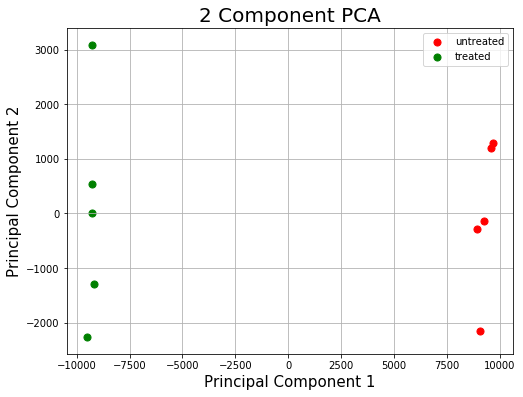

In [28]:
import matplotlib.pyplot as plt

#graficki prikaz komponenti PCA analize

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)
conditions = categories; colors = ['r', 'g']
for target, color in zip(conditions,colors):
    indicesToKeep = finalDf['condition'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], 
               finalDf.loc[indicesToKeep, 'principal component 2'], 
               c = color, s = 50)
ax.legend(conditions); ax.grid()

Sa grafika se moze zakljuciti da se sample-ovi klasteruju po grupama, tako da se svi razmatraju u daljoj analizi

#### 4.Deo - Analiza diferencijalno ekspresovanih gena 

In [29]:
#racunanje p vrednosti gena
def welch_test(a, b):
    # pandas.Series.var() returns an unbiased variance estimate, normalized by N-1 by default
    var_a = a.var()
    var_b = b.var()
    
    Na = len(a)
    Nb = len(b)

    # std deviation estimate
    s = np.sqrt(var_a/Na + var_b/Nb)

    # calculate the t-statistics
    t = (a.mean() - b.mean())/s

    # degrees of freedom - Welch–Satterthwaite equation, yeah it's a bit more complicated than Na + Nb - 2
    deg = (((var_a)/Na + (var_b)/Nb)**2)/ ((var_a**2)/(Na**2*(Na-1)) + (var_b**2)/(Nb**2*(Nb-1)))

    # p-value after comparison with the t     
    p = 2*stats.t.sf(np.abs(t), deg)
    return (p)

In [31]:
# testiranje bez kontrole

p = [(index, welch_test(row.values[0:5], row.values[5:10])) for index, row in normdf.iterrows()]

In [37]:
# prikaz p-vrednosti za gene

res = pd.DataFrame(p, columns=['gene', 'pval'])
res = res.set_index('gene')
res.head(10)

,pval
gene,
5S_rRNA,6.110166e-01
5_8S_rRNA,9.746004e-01
AAR2,3.843004e-01
ABALON,3.154008e-01
ABBA01031660.1,1.526087e-06
ABBA01031661.1,9.258404e-01
ABBA01031663.1,1.513910e-04
ABBA01031674.1,3.846949e-01
ABHD12,9.034846e-01


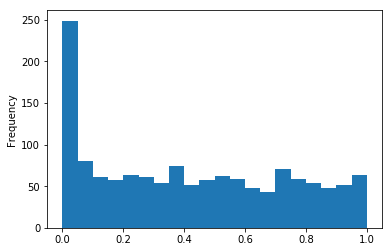

In [38]:
#prikaz raspodele p vrednosti 
res['pval'].plot.hist(bins=20)

In [43]:
# odredjivanje diferencijalno ekspresovanih gena bez kontrole

alpha = 0.05

res['de'] = res['pval'] <= alpha

de_count = len(res.loc[res['de'] == True])
fp_expect = round(res.shape[0] * alpha)

print('Broj diferencijalno ekspresovanih:' + str(de_count))
print('Ocekivano false positive-a:' + str(fp_expect))

res.head(10)

Broj diferencijalno ekspresovanih:249
Ocekivano false positive-a:68


,pval,de
gene,,
5S_rRNA,6.110166e-01,False
5_8S_rRNA,9.746004e-01,False
AAR2,3.843004e-01,False
ABALON,3.154008e-01,False
ABBA01031660.1,1.526087e-06,True
ABBA01031661.1,9.258404e-01,False
ABBA01031663.1,1.513910e-04,True
ABBA01031674.1,3.846949e-01,False
ABHD12,9.034846e-01,False


In [46]:
# Benjamini-Hochberg kontrola je izabrana za FDR 

res.sort_values(by = ['pval'], inplace = True)

m = res.shape[0]
qvals_fdr = []
des_fdr = []

for i in range(m):
    qval = res.iloc[i, 0] * m / (i + 1)
    des_fdr.append(True if qval < alpha else False)
    qvals_fdr.append(qval)  
    
res['qval_fdr'] = qvals_fdr
res['de_fdr'] = des_fdr

de_count_fdr = len(res.loc[res['de_fdr'] == True])
fp_expect_fdr = round(alpha * de_count)

print('Broj diferencijalno ekspresovanih sa FDR kontrolom:' + str(de_count_fdr))
print('Ocekivano false positive-a sa FDR kontrolom:' + str(fp_expect_fdr))

res.head(10)

Broj diferencijalno ekspresovanih sa FDR kontrolom:157
Ocekivano false positive-a sa FDR kontrolom:12


,pval,de,qval_fdr,de_fdr
gene,,,,
XKR7,3.190711e-11,True,4.364893e-08,True
KCNS1,2.112683e-10,True,1.445075e-07,True
FLJ16779,1.000944e-09,True,4.564305e-07,True
HRH3,1.770780e-09,True,6.056067e-07,True
NSFL1C,1.018235e-08,True,2.785890e-06,True
CABLES2,1.511484e-08,True,3.446184e-06,True
RBL1,1.694352e-08,True,3.311247e-06,True
MATN4,1.890226e-08,True,3.232286e-06,True
NKAIN4,4.159494e-08,True,6.322432e-06,True


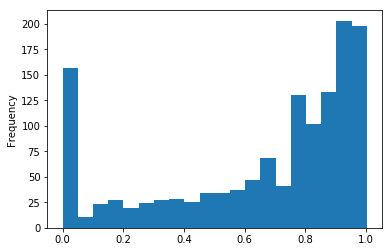

In [47]:
# raspodela q vrednosti sa FDR kontrolom
res['qval_fdr'].plot.hist(bins=20)

In [71]:
# Bonferroni  kontrola je izabrana za FWER

des_fwer = [res.iloc[i, 0] < alpha / m for i in range(m)]
    
res['de_fwer'] = des_fwer

de_count_fwer = len(res.loc[res['de_fwer'] == True])
fp_expect_fwer = 0

print('Broj diferencijalno ekspresovanih sa FWER kontrolom:' + str(de_count_fwer))
print('Ocekivano false positive-a sa FWER kontrolom:' + str(fp_expect_fwer))

res.head(10)

Broj diferencijalno ekspresovanih sa FWER kontrolom:80
Ocekivano false positive-a sa FWER kontrolom:0


,pval,de,qval_fdr,de_fdr,qval_fwer,de_fwer
gene,,,,,,
XKR7,3.190711e-11,True,4.364893e-08,True,4.364893e-08,True
KCNS1,2.112683e-10,True,1.445075e-07,True,2.890150e-07,True
FLJ16779,1.000944e-09,True,4.564305e-07,True,1.369292e-06,True
HRH3,1.770780e-09,True,6.056067e-07,True,2.422427e-06,True
NSFL1C,1.018235e-08,True,2.785890e-06,True,1.392945e-05,True
CABLES2,1.511484e-08,True,3.446184e-06,True,2.067710e-05,True
RBL1,1.694352e-08,True,3.311247e-06,True,2.317873e-05,True
MATN4,1.890226e-08,True,3.232286e-06,True,2.585829e-05,True
NKAIN4,4.159494e-08,True,6.322432e-06,True,5.690188e-05,True


Text(0.5,1,'Graficko uporedjivanje setova diferencijalno ekspresovanih gena')

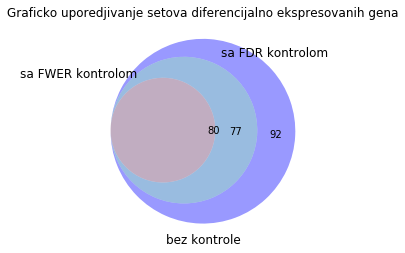

In [61]:
#graficko uporedjivanje setova diferencijalno ekspresovanih gena

from matplotlib_venn import venn3

no_correction_de_genes = list(res.loc[res['de'] == True].index)
fdr_correction_de_genes = list(res.loc[res['de_fdr'] == True].index)
fwer_correction_de_genes = list(res.loc[res['de_fwer'] == True].index)


venn3([set(fwer_correction_de_genes), set(fdr_correction_de_genes), set(no_correction_de_genes)], set_labels = ('sa FWER kontrolom', 'sa FDR kontrolom', 'bez kontrole'))
plt.title('Graficko uporedjivanje setova diferencijalno ekspresovanih gena')

Sa velikom sigurnoscu se moze reci da su geni iz seta sa FWER kontrolom svi diferencijalno ekspresovani, jer je verovatnoca false-positive-a veoma mala i kao sto je ocekivano taj set je najmanji. Ali je pritom verovatnoca false-negativa dosta veca.

Set sa FDR kontolom obuhvata FWER set (nadskup), i jos 77 gena od kojih su izvesno neki false-positive-i.

Set bez kontrole ovuhvata prethodna 2 i jos 92 gena medju kojima je dosta false-postive.

Za krajnji rezultat u pogledu diferencijalne ekspresije gena uzecemo rezultate sa FDR kontrolom kao balans izmedju druga dva seta.



In [94]:
#ispis rezultata u csv

res_csv = pd.DataFrame(res['de_fdr'])
res_csv = res_csv.rename(index = str, columns = {'de_fdr':'differentially_expressed'})
res_csv.index.names = ['gene_id'] 

res_csv.to_csv('result_de.csv', sep = '\t')